This code demonstrates the 'calibration' of NMR data using slug tests from boreholes. The slug tests are used to estimate the K at the screened interval of the bores and we use these K values to estimate an optimal constant for the two equations.

Neil Symington

neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils, SNMR_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def resample_categorical_intervals(df, parameter_columns,
                                   interval_columns, new_intervals):
    # If the parameter input is a string and not a list make it a list
    if isinstance(parameter_columns, ("".__class__, u"".__class__)):
        parameter_columns = [parameter_columns]
    
    # Create a dataframe to add to
    df_resampled = pd.DataFrame(columns = interval_columns, data = new_intervals)
    
    for p in parameter_columns:
        
        df_resampled[p] = ''
        
        # Iterate through the new intervals
        for i, interval in enumerate(new_intervals):
            
            new_depth_from = interval[0]
            new_depth_to = interval[1]

            mask = (df[interval_columns[0]] < new_depth_to) & (df[interval_columns[1]] > new_depth_from)
            
            v = df[mask][p].mode()
            
            if len(v) == 1:
                
                df_resampled.at[i, p] = v.values[0]
            
            elif len(v) > 1:

                df_resampled.at[i, p] = 'transition'
    
    return df_resampled

In [4]:
# This function extracts the K profile using the SDR equation

def SDR_K(df, N = 1, C = 4000):
    '''
    df: dataframe containing GMR inversion data
    N: empirical exponent for water content when estimating the water content
    C: empirical constant for estimating water content
    '''
    return C * df['Total_water_content'].values * df['T2'].values
    #return C * np.power(df['Total_water_content'].values, N) * np.square(df['T2'].values)

def TC_K(df, N = 2, C=4000):
    """
    Function for calculating hydraulic conductivity using the TC equation

    :param mobile_water_content: flat array with mobile water content
    values
    :param total_water_content: flat array with total water content
    values
    :param N: empirical exponent for water content when estimating
     the water content
    :param C: empirical constant for estimating water content
    :return:
    hydraulic conductivity profile as array
    """

    return C * np.power(df['Total_water_content'], N) * np.divide(
        np.power(df['Total_water_content'], N),
        np.subtract(np.power(df['Total_water_content'], N),
                    np.power(df['Free_water_content'], N)))

def objective_function(df, C, N, equation= 'SDR', loss_fn = 'L2'):
    if equation == 'SDR':
        # Find an estimate of log10 K
        df['bNMR_K'] = SDR_K(df, N = N, C = C)
    if equation == 'TC':
        # Find an estimate of log10 K
        df['bNMR_K'] = TC_K(df, N = N, C = C)
    # Retrun the sum of the squares
    if loss_fn == 'L2':
        return ((df['bNMR_K'] - df['K'])**2).sum()
    if loss_fn == 'L1':
        return (np.abs(df['bNMR_K'] - df['K'])).sum()

In [5]:
# First import the slug test data

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\slug_test\compiledSlugtestResults_Keep.xlsx"

df_slugs = pd.read_excel(infile)

In [6]:
# In lieau of a better approach we will average the log of the hydraulic conductivity for each
# bore

df_slugs['log_K'] = np.log10(df_slugs['K estimate (m/day)'].values)

df_logK = df_slugs.groupby(['borehole_id']).min()[['log_K']]



In [7]:
# Now we want to know the screened interval and other spatial information so we open up the 
# borehole database

path = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\mod_spatialite-4.3.0a-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = makeCon(DB_PATH)

Connected to \\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


In [9]:
cols = ['Easting','Northing', 'Borehole_name', 'alternative_name', 'Ground_elevation_mAHD', 'borehole_id']

df_header = borehole_utils.extract_sql_with_primary_key("borehole", cols,  connection, df_logK.index,
                                                        verbose = True)
cols = ['Depth_from','Depth_to', 'Construction_name', 'borehole_id']

df_construction = borehole_utils.extract_sql_with_primary_key('borehole_construction', cols, connection, df_logK.index,
                                                        verbose = True)
# Only keep the screened interval

df_construction = df_construction[df_construction['Construction_name'] == 'screen']

df_merged = df_logK.merge(df_header, on = 'borehole_id').merge(df_construction, on = 'borehole_id')


select t.Easting, t.Northing, t.Borehole_name, t.alternative_name, t.Ground_elevation_mAHD, t.borehole_id from borehole t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);
select t.Depth_from, t.Depth_to, t.Construction_name, t.borehole_id from borehole_construction t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);


In [10]:
# Now we want to find the stratigraphy at each hole

infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\EK_SonicStratigraphySummary.csv"

df_interp = pd.read_csv(infile)

# Add a stratigraphy column
df_merged['stratigraphy'] = ''

for index, row in df_merged.iterrows():
    
    new_intervals = pd.DataFrame(columns = ['Depth_from', 'Depth_to'],
                                 data = np.array([[row.Depth_from, row.Depth_to]]))
    
    # Subset the interpreted dataframe
    eno = row.borehole_id
    
    # Get the stratigraphy for the borehole
    df_strat_subset = borehole_utils.extract_by_primary_key(df_interp, eno)
    
    # If stratigraphy data exists then get it for this interval
    
    if df_strat_subset is not None:
        strat = resample_categorical_intervals(df_strat_subset, ['stratigraphy'],
                                       ['Depth_from', 'Depth_to'], new_intervals.values)['stratigraphy'].values[0]
    # Otherwise I am assured it is in the Permo-Carboniferous
    else:
        strat = 'Permo-Carboniferous'
    
    df_merged.at[index, 'stratigraphy'] = strat

In [10]:
# Get the bNMR

cols = ['Depth', 'Total_water_content','Clay_water_content', 'Capillary_water_content',
        'Free_water_content', 'T2', 'borehole_id']

df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", cols, connection, df_logK.index,
                                                verbose = True)

select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.T2, t.borehole_id from boreholeNMR_data t where t.borehole_id in (635728,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635745,635921);


In [11]:
# For each bore with slug test results we will find all of the javelin observations
# for the screened interval and average them and add them to the merge dataframe

# Define the columns to add to the dataframe
cols = ['Total_water_content', 'Clay_water_content',
       'Capillary_water_content', 'Free_water_content', 'T2']

for c in cols:
    df_merged[c] = np.nan

for index, row in df_merged.iterrows():
    
    # Subset the interpreted dataframe
    eno = row.borehole_id
    
    # Get the stratigraphy for the borehole and average
    df_bNMR_subset = borehole_utils.extract_by_primary_key(df_bNMR, eno)
    
    # Subset based on the screenen interval and average
    
    mask = (df_bNMR_subset['Depth'] >= row.Depth_from) & (df_bNMR_subset['Depth'] <= row.Depth_to)
    
    interval_bNMR = df_bNMR_subset[mask].mean()
    
    # Add this to the df_merged dataframe
    df_merged.at[index, cols] = interval_bNMR[cols]
    


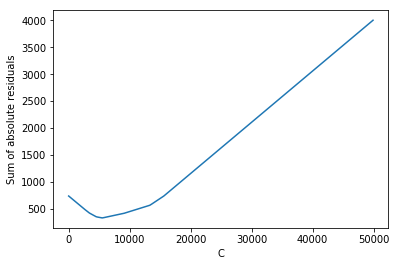

5510


In [12]:
# Now we have the data we can easily estimate the hydraulic conductivity from 
# for values of C and use this to find the optimal value of C for each formation

formation = "Cenozoic sediments"

df_opt = df_merged[df_merged['stratigraphy'] == formation][['log_K','Free_water_content',
                                                            'Total_water_content', 'T2']]

# Do a linear transform

df_opt['K'] = 10**df_opt['log_K']

# Scan a number of different C values

C_vals = np.arange(10,50000, 100)

sum_of_squares = np.nan*np.ones(shape = C_vals.shape)

for i, c in enumerate(C_vals):
    sum_of_squares[i] = objective_function(df_opt, c, 2, equation= 'SDR', loss_fn = 'L1')

# Explore the results

# Find the C that produces the minimum of the residuals

best_C = C_vals[np.argmin(sum_of_squares)]
plt.close()
plt.plot(C_vals,sum_of_squares)
plt.ylabel('Sum of absolute residuals')
plt.xlabel('C')
plt.show()

print(best_C)

In [13]:

objective_function(df_opt, best_C, 2, equation= 'SDR', loss_fn = 'L1')

df_opt

,log_K,Free_water_content,Total_water_content,T2,K,bNMR_K
0,1.711760,0.146151,0.435499,0.013192,51.494400,31.655784
2,1.642121,0.113160,0.180291,0.071491,43.865280,71.019397
3,0.897555,0.062590,0.260660,0.012966,7.898688,18.621710
8,1.970339,0.168761,0.355836,0.047406,93.398400,92.946907
9,2.417096,0.136478,0.213240,0.091863,261.273600,107.934451
10,1.860120,0.122223,0.262653,0.060602,72.463680,87.704015
11,1.206960,0.057359,0.273206,0.013381,16.104960,20.143783
12,1.553829,0.087087,0.243707,0.027432,35.795520,36.837009
13,2.203920,0.140610,0.330593,0.031131,159.926400,56.707277


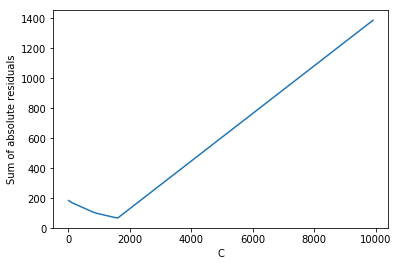

1610


In [14]:
# Now we have the data we can easily estimate the hydraulic conductivity from 
# for values of C and use this to find the optimal value of C for each formation

formation = "Permo-Carboniferous"

df_opt = df_merged[df_merged['stratigraphy'] == formation][['log_K','Free_water_content',
                                                            'Total_water_content', 'T2']]

# Do a linear transform

df_opt['K'] = 10**df_opt['log_K']

# Scan a number of different C values

C_vals = np.arange(10,10000, 100)

sum_of_squares = np.nan*np.ones(shape = C_vals.shape)

for i, c in enumerate(C_vals):
    sum_of_squares[i] = objective_function(df_opt, c, 1, equation= 'SDR', loss_fn = 'L1')

# Explore the results

# Find the C that produces the minimum of the residuals

best_C = C_vals[np.argmin(sum_of_squares)]
plt.close()
plt.plot(C_vals,sum_of_squares)
plt.ylabel('Sum of absolute residuals')
plt.xlabel('C')
plt.show()

print(best_C)

In [15]:
objective_function(df_opt, best_C, 2, equation= 'SDR', loss_fn = 'L1')

df_opt

,log_K,Free_water_content,Total_water_content,T2,K,bNMR_K
1,0.246144,NaN,NaN,NaN,1.762560,NaN
4,-0.102018,0.101128,0.232752,0.029820,0.790646,11.174579
5,2.218002,0.194617,0.213494,0.483520,165.196800,166.197890
6,0.134896,0.134334,0.180654,0.115600,1.364256,33.622675
7,-0.306090,0.099250,0.289561,0.019858,0.494208,9.257516
14,1.269961,0.231085,0.277390,0.078966,18.619200,35.266218


In [92]:
# Export the results
df_merged.dropna(how='any').to_csv(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\borehole_NMR\boreholes_NMR_screen_average.csv")